### Testing the ```utils.Filehandling.FileHandlingInterface``` module

In [1]:
from utils.FileHandling.FileHandlingInterface import *
from probabilityEstim.Likelihood import *
import matplotlib.pyplot as plt

#### Testing the ```TargetImage``` class for the Pascal dataset

Defining path to the sample image

In [2]:
PASCAL_DEMO_IMAGE_PATH = r"data\Pascal\scribble_annotation\scribble_annotation\demo\2008_003147.jpg"

Initializing the ```TargteImage``` Object

In [3]:
sample_image = TargetImage(
    PASCAL_DEMO_IMAGE_PATH              
)

Testing ```TargetImage.get_image_array``` method

In [4]:
image_array = sample_image.get_image_array()

In [5]:
image_array.shape

(3, 500, 375)

Testing ```TargetImage.get_image_shape``` method

In [6]:
sample_image.get_image_shape() 

(500, 375)

Testing ```TargetImage.get_image_channels``` method

In [7]:
sample_image.get_image_channels()

3

Showing the Image array

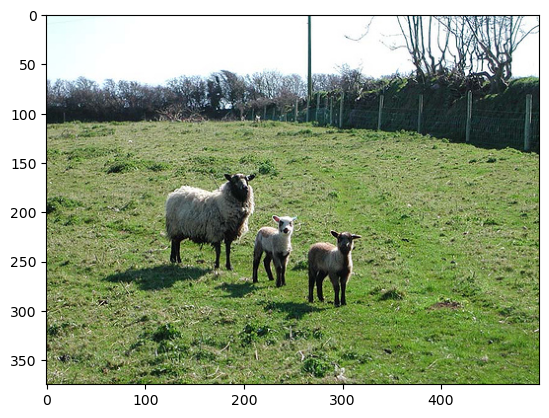

In [8]:
plt.imshow(image_array.transpose((2, 1, 0)))

### Testing the ```EncodedScribble``` class for the Pascal daatset

Defining path to the sample scribble file

In [9]:
PASCAL_DEMO_SCRIBBLE_PATH = r"data\Pascal\scribble_annotation\scribble_annotation\demo\2008_003147.xml"

Initializing the ```EncodedScribble``` object

In [10]:
sample_scribble = EncodedScribble(PASCAL_DEMO_SCRIBBLE_PATH)

Testing the ```EncodedScribble.get_encoded_scribble``` method

In [11]:
sample_encoded_scribble = sample_scribble.get_encoded_scribble()

In [12]:
n_classes = len(sample_encoded_scribble)

In [13]:
likelihood = Likelihood(n_classes, on_gpu = True)

In [14]:
import logging
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.DEBUG)

In [15]:
import os 
os.environ['NUMBA_ENABLE_CUDASIM'] = '0'

In [16]:
import time
import warnings
warnings.simplefilter("always", RuntimeWarning)
time0 = time.time()
with warnings.catch_warnings(record=True) as w:
    fitted_likelihood = likelihood.fit(
        sample_image, 
        sample_scribble
    )
    if len(w) > 0:
        # Print the warning message
        print("Floating point overflow occurred:", w[-1].message)
print(f"{time.time() - time0}")

3.4764652252197266


In [17]:
classes = list(sample_scribble.get_scribble_dictionary().keys())

In [18]:
np.sum(np.isnan(fitted_likelihood))

562500

In [19]:
np.unravel_index(np.argmin(fitted_likelihood[0], axis=None), fitted_likelihood[0].shape)

(0, 0)

In [20]:
np.min(fitted_likelihood)

nan

In [21]:
fitted_likelihood[2, 496, 88]

0.0

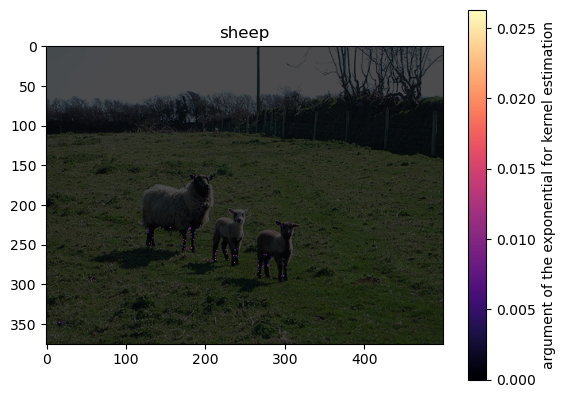

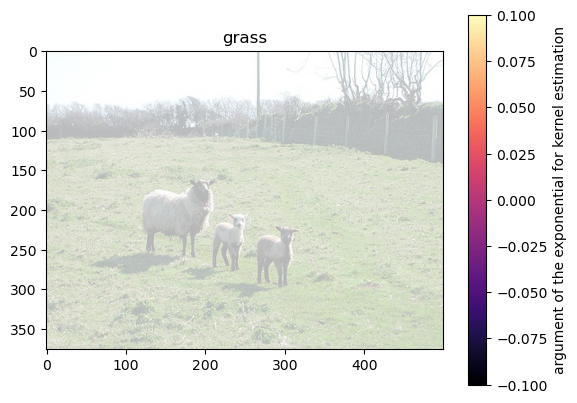

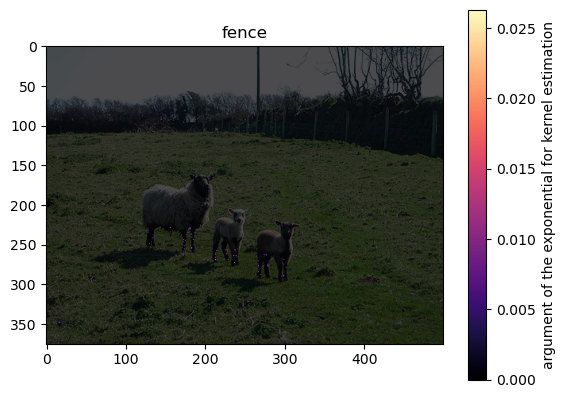

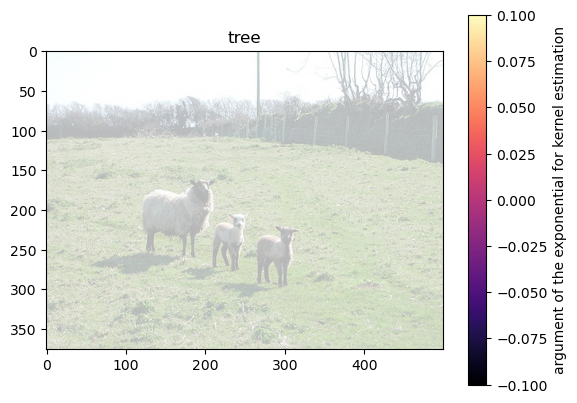

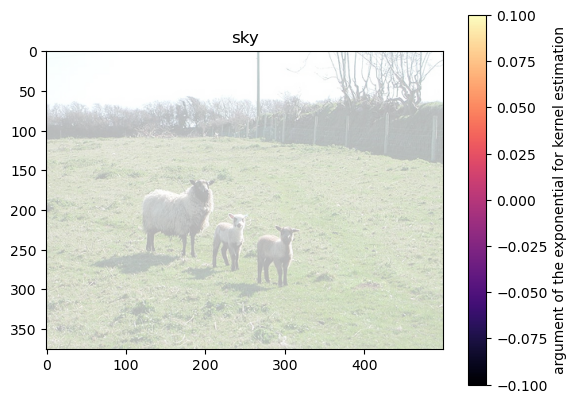

In [22]:
for dim in range(fitted_likelihood.shape[0]):
    # Create a new figure and axis for each plot
    fig, ax = plt.subplots()
    
    vmin = np.min(fitted_likelihood[dim])
    vmax = np.max(fitted_likelihood[dim])
    im1 = ax.imshow(fitted_likelihood[dim].transpose((1, 0)), cmap='magma', alpha=1.0, vmin=vmin, vmax=vmax)
    
    # Add a title and colorbar legend to the plot
    ax.set_title(classes[dim]) 
    fig.colorbar(im1, ax=ax, label='argument of the exponential for kernel estimation')
    
    # Plot the image array on the same axis
    im2 = ax.imshow(image_array.transpose((2, 1, 0)), alpha=0.3)
    
    
    # Save the plot as a PNG image file
    fig.savefig(f'plots/chromoKernel/plot{classes[dim]}.png', dpi=300)
    # Show the plot
    plt.show()


In [23]:
#3295707168695395.0
fitted_likelihood[0, 0, 100]

1.332317366e-315

In [24]:
# one pixel below/above or r/l

math.exp(-0.5)/(2*math.pi)

0.09653235263005391

In [25]:
# two pixels below/above or r/l

math.exp(-2 * math.sqrt(2))/(2*math.pi*math.sqrt(2))

0.006651733501046996

(x1, y1) ((i, 0), 
          (0, i)) (x1, y1)   (x1i, y1i)(x1, y1) = i*x1^2 + i*y1^2 
          

In [26]:
def find_scribble_point_with_minimum_distance(
        x_coord: int, 
        y_coord: int, 
        scribble_coordinates: cp.ndarray
    ) -> float:
    l2_distance = lambda x1, x2, y1, y2: math.sqrt(((x1 - x2)**2 + (y1 - y2)**2)) 
    min_distance = math.inf
    n_scribble_pixels = scribble_coordinates.shape[0] # flat vector, only one element
    x_coord = np.int64(x_coord)
    y_coord = np.int64(y_coord)
    for idx in range(n_scribble_pixels):
        x_coord_scribble, y_coord_scribble = scribble_coordinates[idx]
        # l2 distance
        x_coord_scribble = np.int64(x_coord_scribble)
        y_coord_scribble = np.int64(y_coord_scribble)
        distance = l2_distance(
            x_coord, 
            x_coord_scribble, 
            y_coord, 
            y_coord_scribble
        )
        if distance < min_distance:
            min_distance = distance
    return min_distance

In [27]:
find_scribble_point_with_minimum_distance(131, 210, sample_encoded_scribble[0])

0.0

In [28]:
import numpy
from numba import cuda

@cuda.reduce
def sum_reduce(a, b):
    return a + b


A = (numpy.arange(1234, dtype=numpy.float64)) + 1
expect = A.sum()      # numpy sum reduction
got = sum_reduce(A)   # cuda sum reduction
assert expect == got

C:\Users\lollo\anaconda3\envs\graphical_models\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\lollo\anaconda3\envs\graphical_models\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\Users\lollo\anaconda3\envs\graphical_models\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [29]:
got

761995.0